### Install the classification and plotting libraries

In [1]:
!pip install pytorch-tabnet -q
!pip install mplsoccer -q

In [43]:
import pandas as pd
import requests
from io import StringIO
import numpy as np
import gc

orig_url='https://drive.google.com/file/d/1OWRqfE-YXWja5XWRjl6pgV-hDdW0dG-k/view'

file_id = orig_url.split('/')[-2]
dwn_url='https://drive.google.com/uc?export=download&id=' + file_id
url = requests.get(dwn_url).text
csv_raw = StringIO(url)
df = pd.read_csv(csv_raw)

In [3]:
df.head()

,id,minute,result,X,Y,xG,player,h_a,player_id,situation,year,shotType,match_id,h_team,a_team,h_goals,a_goals,date,player_assisted,lastAction
0,378451.0,20,BlockedShot,0.876,0.602,0.019479,Ollie Watkins,h,8865,OpenPlay,2020,Head,14104,Aston Villa,Sheffield United,1,0,2020-09-21 17:00:00,Matthew Cash,Aerial
1,378458.0,54,MissedShots,0.878,0.430,0.031428,Ollie Watkins,h,8865,OpenPlay,2020,Head,14104,Aston Villa,Sheffield United,1,0,2020-09-21 17:00:00,TrÃ©zÃ©guet,Cross
2,378464.0,77,MissedShots,0.858,0.679,0.060696,Ollie Watkins,h,8865,OpenPlay,2020,RightFoot,14104,Aston Villa,Sheffield United,1,0,2020-09-21 17:00:00,John McGinn,Pass
3,379954.0,34,MissedShots,0.831,0.655,0.127710,Ollie Watkins,a,8865,OpenPlay,2020,RightFoot,14114,Fulham,Aston Villa,0,3,2020-09-28 17:00:00,Jack Grealish,TakeOn
4,379956.0,46,MissedShots,0.943,0.500,0.445354,Ollie Watkins,a,8865,FromCorner,2020,Head,14114,Fulham,Aston Villa,0,3,2020-09-28 17:00:00,Conor Hourihane,Cross


### Feature-building 

In [44]:
%%time

target = 'isGoal'

def get_angle(b):
    b = np.array(b)
    a = np.array([100,45])
    c = np.array([100,55])
    ba = a - b
    bc = c - b

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)
    return np.degrees(angle)

df = df[~df['result'].isin(['BlockedShot', 'OwnGoal'])]

df[target] = df['result'].map({'MissedShots': 0, 
                               'SavedShot': 0, 
                               'ShotOnPost': 0, 
                               'Goal': 1})

df["h_state"] = np.where(df["h_goals"]==df["a_goals"], 2, np.where(df["h_goals"]>df["a_goals"], 1, 0)) ##get home state
df["a_state"] = df["h_state"].map({2:2, 1:0, 0:1}) ##get away state by inverting home state

df["game_state"] = np.where(df["h_a"]=='h', df["h_state"], df["a_state"]) ##get game_state of given team (h/a)
df.drop(["a_goals", "h_goals", "h_a"], axis=1, inplace=True) ##drop the columns we don't need anymore
df["shotType"] = df["shotType"].map({'RightFoot':0, 
                                        'LeftFoot':0,
                                        'OtherBodyPart':2, 
                                        'Head':1}) ##map to bodypart

df["situation"] = df["situation"].map({"OpenPlay": 0,
                                        "FromCorner":1, 
                                        "SetPiece": 2, 
                                        "DirectFreekick": 3}) ##map to situations

df["minute"] = df["minute"]/90.0    ###normalising doesn't matter in gradient-boosted tree models but it's a good practice anyway  


df[["X", "Y"]] = df[["X", "Y"]]*100
df["goal_x"] = 100
df["goal_y"] = 50
df["length"] = np.sqrt( np.square(df["goal_x"] - df["X"]) + np.square(df["goal_y"] - df["Y"]) )
df["angle"] = df[["X", "Y"]].apply(get_angle, axis=1)
df = df.dropna().reset_index(drop=True)

CPU times: user 7.41 s, sys: 70 ms, total: 7.48 s
Wall time: 7.45 s


### Scaling and splitting

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
cont_features = ['minute', 'X', 'Y', 'length', 'angle']
df[cont_features] = scaler.fit(df[cont_features]).transform(df[cont_features]) 

_ = gc.collect()
features = ['minute', 'X', 'Y', 'situation', 'shotType', 'game_state', 'length', 'angle']
target = 'isGoal'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

### Fit the Model

In [46]:
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor

from pytorch_tabnet.metrics import Metric
from sklearn.metrics import roc_auc_score

clf = TabNetClassifier()  #TabNetRegressor()
clf.fit(
  X_train.values, y_train.values,
  eval_set=[(X_valid.values, y_valid.values)]
)
preds = clf.predict(X_test.values)

Device used : cuda
epoch 0  | loss: 0.34276 | val_0_auc: 0.78674 |  0:00:04s
epoch 1  | loss: 0.32354 | val_0_auc: 0.79849 |  0:00:09s
epoch 2  | loss: 0.32276 | val_0_auc: 0.80023 |  0:00:13s
epoch 3  | loss: 0.32137 | val_0_auc: 0.80227 |  0:00:17s
epoch 4  | loss: 0.32104 | val_0_auc: 0.80087 |  0:00:22s
epoch 5  | loss: 0.32023 | val_0_auc: 0.80203 |  0:00:26s
epoch 6  | loss: 0.32003 | val_0_auc: 0.80454 |  0:00:31s
epoch 7  | loss: 0.31939 | val_0_auc: 0.79818 |  0:00:35s
epoch 8  | loss: 0.31993 | val_0_auc: 0.80388 |  0:00:40s
epoch 9  | loss: 0.31859 | val_0_auc: 0.80538 |  0:00:44s
epoch 10 | loss: 0.31884 | val_0_auc: 0.80532 |  0:00:49s
epoch 11 | loss: 0.31831 | val_0_auc: 0.80375 |  0:00:53s
epoch 12 | loss: 0.31918 | val_0_auc: 0.80428 |  0:00:57s
epoch 13 | loss: 0.31922 | val_0_auc: 0.8046  |  0:01:02s
epoch 14 | loss: 0.3187  | val_0_auc: 0.80553 |  0:01:06s
epoch 15 | loss: 0.31846 | val_0_auc: 0.80452 |  0:01:11s
epoch 16 | loss: 0.31878 | val_0_auc: 0.80474 |  0:01

### Inference

In [47]:
preds = clf.predict_proba(X_test.values)[:, 1]

In [48]:
roc_auc_score(y_test.values, preds)

0.7949976929615218

In [ ]:
##invert the standard scaler transformation
inv_data = scaler.inverse_transform(X_test[cont_features])
cxs = inv_data[:, 1]
cys = inv_data[:, 2]

#### Eye-test: Plot the pitch and shots

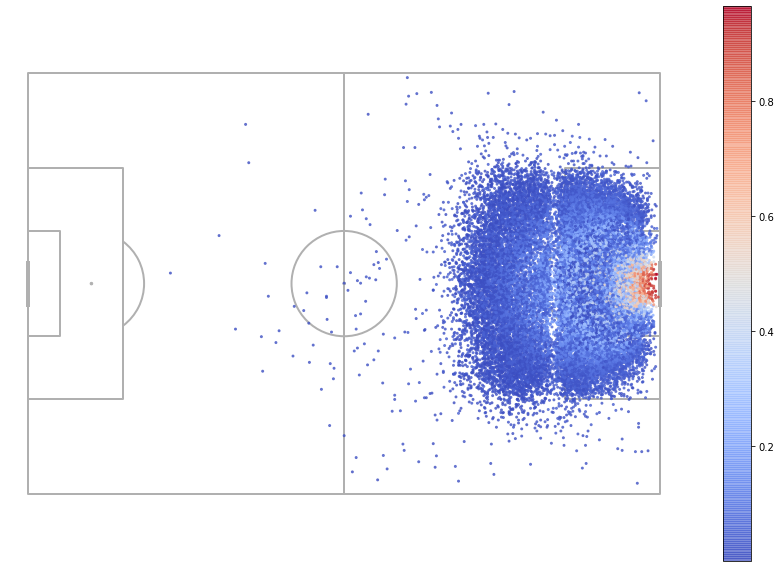

In [58]:
from mplsoccer.pitch import Pitch
pitch = Pitch()
fig, ax = pitch.draw(figsize=(12,8))
im = ax.scatter(cxs*1.2, cys*0.8, c=preds, cmap="coolwarm", alpha=0.7, s=4)
fig.colorbar(im);